## Here we will analyze tennis first-serve data. In this case, the mock data that we generated with mock_data_generator.ipynb and saved in formatted_mock_data.

## We want to look at correlations between each service (if the first serve went in, what is the chance it goes in on the next point?).

## For the mock data, we generated two data sets, one with a hot hands magnitude of 10% (if the first serve went out, there is a 10% higher chance that the next first serve will also miss). The other has no hot hands effect. I.e. the first serve's chance of going in is independent of whether or not the last serve went in (i.e., there is no correlation between subsequent serves).

## First things first, lets generate our data structure class to hold everything.

In [66]:
import json

class Data(object):
    def __init__(self, serve_data=None):
        self.serve_data = serve_data

    def __getitem__(self, player_id):
        return self.serve_data[player_id]

    @property
    def player_ids(self):
        return list(self.serve_data.keys())

    @classmethod
    def load(cls, path):
        with open(path, 'r') as file:
            serve_data = json.load(file)
        serve_data = {int(key): val for key, val in serve_data.items()} # get rid of the string keys.
        return cls(serve_data)

# first, lets load in the mock data:
case0 = Data.load('formatted_mock_data/case0.json')
case0p1 = Data.load('formatted_mock_data/case0p1.json')

Now we can easily pull each set of data for each player as follows, (in the following example, player 0, both for case 0 (no hot/cold hands effect))

In [67]:
print(case0[0][5], 'player 0, set 5')
print(case0[0][30], 'player 0, set 30 (note that we combined all matches sets)')

[1, 1, 0, 1, 0, 1] player 0, set 5
[1, 0, 1, 1, 0, 0] player 0, set 30 (note that we combined all matches sets)


## Now we want to compute 2 conditional probabilities, for each player:
## P(G|LG) where G is the event that the current serve goes in, and LG is the event that the last serve went in also.
## And P(G|LF) : the probability of this serve going in, given that the last serve was a fault.

### In case0, We should recover that P(G|LG) = P(G|LF), because by design, in the mock data, we set this effect to 0.
### in the case0p1, we should recover that P(G|LG) is 0.1 larger than P(G|LF). Because we set that the chance of going in was 10% higher if the last serve went in also.

### A note on estimating conditional probabilities. To calculate P(F|LF) , we will want to select pairs of events where the first in the sequence (the last serve) was a fault -- then among those sequences, we want to count how many have the second item as a fault as well. Similarly for P(G|LF) = (number of good serves where the first serve is a fault) / (total number of sequences where the first in the sequence is a fault.)

### So let's go ahead and write a function to estimate those probabilities for a give player. We are going to do this in a very explicit pedagogical way, writing everything out by hand. This is not a streamlined approach.

In [148]:
from astropy.table import Table
import numpy as np

def estimate_conditional_probability(player_serve_data):
    # there is a nuance here that we havent taken into account. pglg is simply more likely, because
    # the sequence [1, 1] is more likely than the sequence [1, 0] because all these players have
    # a higher chance of making a shot 
    num_good_with_good_last_serve = 0
    num_good_with_bad_last_serve = 0
    num_bad_with_bad_last_serve = 0
    num_bad_with_good_last_serve = 0
    total_lg = 0
    total_lf = 0
    for game in player_serve_data:
        for i in range(1, len(game)):
            if game[i-1] == 1:
                total_lg += 1
                if game[i] == 1:
                    num_good_with_good_last_serve += 1
                if game[i] == 0:
                    num_bad_with_good_last_serve += 1
            if game[i-1] == 0:
                total_lf += 1
                if game[1] == 1:
                    num_good_with_bad_last_serve += 1
                if game[1] == 0:
                    num_bad_with_bad_last_serve += 1
    total_serves = total_lg + total_lf
    # calculate the conditional probabilities from the counts.
    pglg = num_good_with_good_last_serve / total_lg
    pflg = num_bad_with_good_last_serve / total_lg
    pglf = num_good_with_bad_last_serve / total_lf
    pflf = num_bad_with_bad_last_serve / total_lf
    #print(pglg, pglf)
    pg = (num_good_with_good_last_serve + num_good_with_bad_last_serve)/ total_serves
    pf = (num_bad_with_bad_last_serve + num_bad_with_good_last_serve)/ total_serves
    # calculate the errors from simple Poisson counting statistics.
    e_pglg = np.sqrt(num_good_with_good_last_serve) / total_lg
    e_pflg = np.sqrt(num_bad_with_good_last_serve) / total_lg
    e_pglf = np.sqrt(num_good_with_bad_last_serve) / total_lf
    e_pflf = np.sqrt(num_bad_with_bad_last_serve) / total_lf
    e_pg = np.sqrt(num_good_with_good_last_serve + num_good_with_bad_last_serve)/ total_serves
    e_pf = np.sqrt(num_bad_with_bad_last_serve + num_bad_with_good_last_serve)/ total_serves
    return {'pglg': pglg, 'pglf': pglf, 'pflg': pflg, 'pflf': pflf, 'pg': pg, 'pf': pf,
            'e_pglg': e_pglg, 'e_pglf': e_pglf, 'e_pflg': e_pflg, 'e_pflf': e_pflf, 'e_pg': e_pg, 'e_pf': e_pf}

result = estimate_conditional_probability(case0[0])
print(result['pg'] + result['pf'])
result = estimate_conditional_probability(case0p1[0])
print(result['pg'] + result['pf'])

1.0
1.0


Quick sanity check (this would be e.g. a unit test in an actual code base, but for this 
analysis we will just run this here)
We want to check that the conditional probabilities add up as expected. 

In [149]:
result = estimate_conditional_probability(case0p1[0])
print('probability of having a faulted serve, from two different estimates:')
print(result['pf'] * result['pflf'] + result['pg'] * result['pflg'])
print(result['pf'])
print('probability of having a good serve, from two different estimates:')
estimate = result['pf'] * result['pglf'] + result['pg'] * result['pglg']
print(estimate)
print(result['pg'])
print(f'indeed, these two agree within {np.round(np.abs(estimate - result["pg"]), 4)}. The counting error is: {np.round(result["e_pg"], 4)}, and so these are consistent with each other.')
print(result['pg'] + result['pf'], 'Check that P(G) + P(F) = 1.0')
print('check that Bayes theorem is obeyed: P(F|LG) = P(G|LF)*P(F)/P(G)')
print(result['pflg'], result['pglf'] * result['pf']/result['pg'])
print(result['pglf'], result['pflg'] * result['pg']/result['pf'])
print('And indeed Bayes theorem is obeyed, within the errors.')

probability of having a faulted serve, from two different estimates:
0.2973025643005152
0.2952202436738519
probability of having a good serve, from two different estimates:
0.7026974356994848
0.7047797563261481
indeed, these two agree within 0.0021. The counting error is: 0.0062, and so these are consistent with each other.
1.0 Check that P(G) + P(F) = 1.0
check that Bayes theorem is obeyed: P(F|LG) = P(G|LF)*P(F)/P(G)
0.19948829275856722 0.19653372346515
0.4691852699866438 0.47623871795061123
And indeed Bayes theorem is obeyed, within the errors.


We also want to check that in the no hot hands case, that P(F) = P(F|LF) = P(F|LG) and that P(G) = P(G|LG) = P(G|LF), because subsequent serves have no impact on each other in the hot hands case.

In [147]:
result = estimate_conditional_probability(case0[0])
print(result['pf'], result['pflf'], result['pflg'])
print(result['pg'], result['pglf'], result['pglg'])
print('They all are equal for the null case (within the errors)!')
print('So we can be confident that estimate_conditional_probability() is working properly')

0.5580241468658691 0.6125711782742006 0.5027201065837682
0.4419758531341309 0.3874288217257994 0.4972798934162318
They all are equal for the null case (within the errors)!
So we can be confident that estimate_conditional_probability() is working properly


# Now we estimate the conditional probabilities for every player.

In [79]:
from astropy.table import vstack

def estimate_conditional_probabilities_all_players(case: Data) -> Table:
    statistics = []
    for player_id in case.player_ids:
        result = estimate_conditional_probability(case[player_id])
        result['player_id'] = player_id
        statistics.append(result)
    return vstack(statistics)

case0_statistics = estimate_conditional_probabilities_all_players(case0)
case0p1_statistics = estimate_conditional_probabilities_all_players(case0p1)

## And then plot the difference between P(G|LG) and P(G|LF) for every player, which by design was defined as a constant per player (but may not be the case with real data). Case 0 should have this value centered around 0, and case 0p1 should have this centered around 0.1

-0.10020380352243627
0.40948747248626605


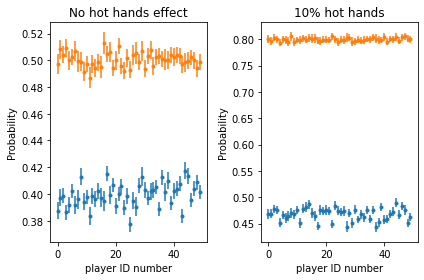

In [141]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2)
for i, case, label in zip([0, 1], [case0_statistics, case0p1_statistics], ['No hot hands effect', '10% hot hands']):
    axes[i].set_title(label)
    axes[i].errorbar(case['player_id'], case['pglf'], yerr=case['e_pglf'], marker='o', 
                     markersize=3, label="P(G|LF)", ls='none')
    axes[i].errorbar(case['player_id'], case['pglg'], yerr=case['e_pglg'], marker='o', 
                     markersize=3, label="P(G|LG)", ls='none')
    axes[i].set_ylabel('Probability')
    axes[i].set_xlabel('player ID number')
    print(np.mean(case['pg'] - case['pf']))
    
plt.tight_layout()
plt.show()

## The right hand panel shows a separation of about 10% -- exactly what we coded in the mock data! Let's make a simple plot of hot hands magntiude (so the orange minus the blue) below.

-0.10020380352243627
0.40948747248626605


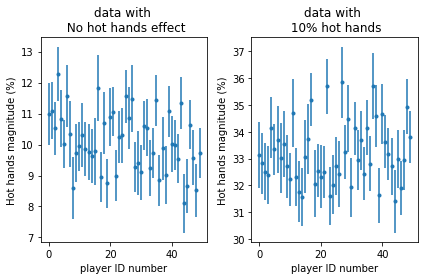

In [92]:
fig, axes = plt.subplots(1, 2)
for i, case, label in zip([0, 1], [case0_statistics, case0p1_statistics], ['data with \n No hot hands effect', 'data with \n 10% hot hands']):
    axes[i].set_title(label)
    axes[i].errorbar(case['player_id'], 100*(case['pglg'] - case['pglf']), 
                     yerr=100*np.sqrt(case['e_pglf']**2 + case['e_pglg']**2), # have to add the errors in quadrature.
                                  marker='o', 
                     markersize=3, label="P(G|LF)", ls='none')
    axes[i].set_ylabel('Hot hands magnitude (%)')
    axes[i].set_xlabel('player ID number')
    print(np.mean(case['pg'] - case['pf']))
    
plt.tight_layout()
plt.show()

## OK so per player, we have single estimates that seem to indicate that there is a hot/cold hands effect in the mock data, exactly at the levels injected. The left hand panel shows an average value bouncing around 0%, and the error bars seem representative of the data (which is good), while the right hand panel shows the effect at 10% -- exactly how we set it up to be. 


## Moreover, from our estimates of the errors on our probability estimates, we know that the hot hand magnitude is statistically significant. 
## With error bars, we can say that player 0 has a hot hands effect of 0.1 +- 0.01 . So for that player, the effect is 10 sigma significant (10 standard deviations from 0). 

## 10 sigma significance is a whopping confirmation of the effect. See https://en.wikipedia.org/wiki/Standard_deviation 
## Even at just 7 sigma, this means that if we repeated this analysis on a new Tennis tournament and new players, with new data, we would need to do it over *390 billion* different times until we observed a 7 sigma separation across all players. And we are at 10 sigma.

## This is the kind of the strong confirmation we want in the real data. But... this all hinges on whether we trust our error bars! If our error estimate is off by a factor of 10, then this result would be insignificant.

## The scatter in the data points is of the order the error bars so that is one validation of our error estimate, but we would like another. For that, we turn to the actual posterior, this is P(H|X) = probability of hot hands magnitude =X as a function of X

## We want an actual posterior (probability as a function of hot hands magnitude) to get another estimate on how significant this hot hands magnitude is. We are going to use something called bootstrap resampling to estimate P(H|X). This is a way to estimate posteriors from a single set of data, provided that dataset is large enough. And ours certainly is (we have tens of thousands of samples (serves) per player).

### In bootstrap resampling, you can typically get away with using 10% of the total number of samples you have. So we can bootstrap resample about 1000 times, because our data set for each player is roughly 10,000 samples large.

In [97]:
def boostrap_estimate_conditional_probabilities(player_serve_data, num_resamples=1000):
    num_sets = len(player_serve_data)
    indices = np.arange(num_sets)
    statistics = []
    for i in range(num_resamples):
        this_sample = np.random.choice(indices, size=len(indices), replace=True)
        player_serve_data_sample = [player_serve_data[i] for i in this_sample]
        result = estimate_conditional_probability(player_serve_data_sample)
        statistics.append(result)
    return vstack(statistics)
    # now we have resampled posterior statistics, for this player, for every conditional probability.

## Let's show our posterior estimate for 1 player, in the no-hot-hands case.

In [126]:
resampled_stats = boostrap_estimate_conditional_probabilities(case0p1[0], num_resamples=1000)

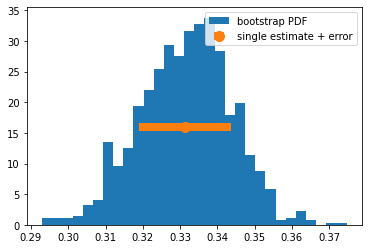

In [127]:
plt.figure()
counts = plt.hist(resampled_stats['pglg'] - resampled_stats['pglf'], bins=30, density=True, label='bootstrap PDF')[0]
formal_estimate = case0p1_statistics[case0p1_statistics['player_id'] == 0]
plt.errorbar(formal_estimate['pglg'] - formal_estimate['pglf'], np.max(counts)//2, 
             xerr=np.sqrt(formal_estimate['e_pglg']**2+ formal_estimate['e_pglf']**2), 
             ls='none', marker='o', markersize=10, lw=8, label='single estimate + error')
plt.legend(loc='best')
plt.show()

## This is excellent! It is great that the width of the bootstrap PDF is roughly equal to the errorbar of our, old, single estimate (which we calculated from standard error propagation). That gives us a lot of confidence in this mock data analysis, and indeed that we were able to recover the 10% hot hands effect with overwhelming 10 sigma confidence.

## Now lets move onto the real data, and the notebook hot_hands_analysis_realdata.ipynb